In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import numpy as np

from tavi.data.tavi import TAVI
from tavi.instrument.resolution.cooper_nathans import CN
from tavi.plotter import Plot2D
from tavi.sample.xtal import Xtal

# load data
tavi = TAVI()
path_to_spice_folder = "../test_data/IPTS9879_HB1A_exp978/exp978/"
tavi.load_spice_data_from_disk(path_to_spice_folder)


/home/x4l/Documents/TAVI/src/tavi/data/spice_reader.py:61: UserWarning: genfromtxt: Empty input file: "../test_data/IPTS9879_HB1A_exp978/exp978/Datafiles/HB1A_exp0978_scan0035.dat"
  data = np.genfromtxt(file_name, comments="#")


/home/x4l/Documents/TAVI/src/tavi/data/scan_data.py:394: RuntimeWarning: invalid value encountered in divide
  self.z = z / counts * norm_val
/home/x4l/Documents/TAVI/src/tavi/data/scan_data.py:395: RuntimeWarning: invalid value encountered in divide
  self.err = np.sqrt(z) / counts * norm_val


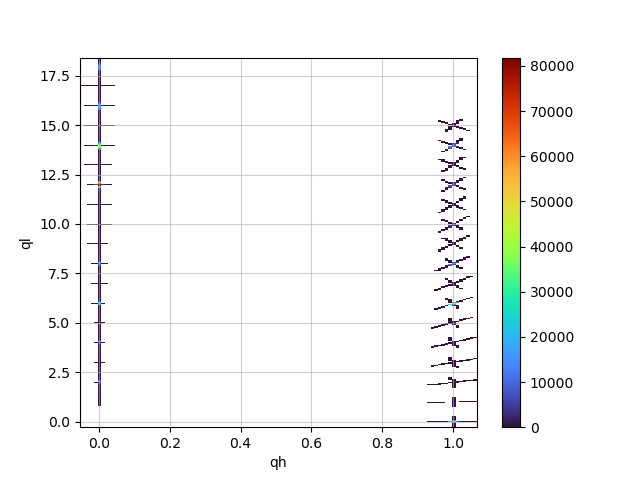

In [2]:
# generate a contour of all scans 
scans = list(range(132, 198 + 1))

scan_group = tavi.combine_scans(scans, name="La2Ni7_40-40-40-80")
scan_group_data = scan_group.get_data(
    axes=("qh", "ql", "detector"),
    norm_to=(1, "mcu"),
    grid=(0.01, 0.05),
)

contour = Plot2D()
contour.add_contour(scan_group_data, cmap="turbo", vmin=0)

fig, ax = plt.subplots()
im1 = contour.plot(ax)
fig.colorbar(im1)

In [3]:
from tavi.utilities import MotorAngles, Peak

instrument_config_json_path = "../test_data/IPTS9879_HB1A_exp978/hb1a_La2Ni7.json"
tas = CN(SPICE_CONVENTION=True)
tas.load_instrument_params_from_json(instrument_config_json_path)

sample_json_path = "../test_data/IPTS9879_HB1A_exp978/La2Ni7.json"
sample = Xtal.from_json(sample_json_path)
ub_json=sample.ub_mat
tas.mount_sample(sample)

# check UB calculation

ei = 14.450292
ef = 14.443601

angles1 = MotorAngles(two_theta=-101.396853, omega=-48.004475, sgl=-0.770162, sgu=1.477665)
peak1 = Peak(hkl=(0, 0, 16), angles=angles1, ei=ei, ef=ef)
angles2 = MotorAngles(two_theta=-56.150124, omega=64.624337, sgl=-0.770162, sgu=1.477665)
peak2 = Peak(hkl=(1, 1, 0), angles=angles2, ei=ei, ef=ef)

tas.calculate_ub_matrix(peaks=(peak1, peak2))
assert np.allclose(tas.sample.ub_mat,ub_json,atol=1e-4)

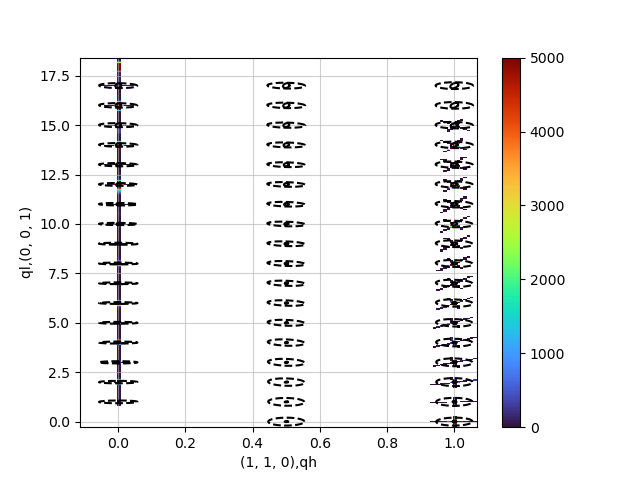

In [4]:

projection=((1, 1, 0), (-2, 1, 0),(0, 0, 1))

# overplot with resoluytion ellipses

hkl_list = [(qh, qh, ql) for ql in np.arange(0, 18, 1) for qh in np.arange(0, 1.5, 0.5)]
hkl_list.pop(0)

rez_list = tas.cooper_nathans(
        hkl_list=hkl_list,
        ei=ei,
        ef=ef,
        projection=projection,
        R0=False,
    )

contour = Plot2D()
contour.add_contour(scan_group_data, cmap="turbo", vmin=0, vmax=5e3)

for rez in rez_list:
    e_co = rez.get_ellipse(axes=(0, 2), PROJECTION=False)
    e_inco = rez.get_ellipse(axes=(0, 2), PROJECTION=True)
    contour.add_reso(e_co, c="k", linestyle="solid")
    contour.add_reso(e_inco, c="k", linestyle="dashed")



fig, ax = plt.subplots()
im1 = contour.plot(ax)
fig.colorbar(im1)

In [5]:
# (002) th2th, scan #132

from tavi.data.fit import Fit1D
from tavi.data.scan import Scan
from tavi.plotter import Plot1D


def analyze_fwhm(hkl, scans, fit_ranges):
    scan1, scan2=scans
    fit_range1,fit_range2=fit_ranges
  
    # ------------------------- th2th -------------------------

    th2th = Scan.from_spice(path_to_spice_folder, scan_num=scan1)
    scan_th2th = th2th.get_data(axes=("del_q","detector"),norm_to=(1, "mcu"))
    # perform fit
    scan_th2th_fit = Fit1D(scan_th2th, fit_range=fit_range1)
    scan_th2th_fit.add_signal(model="Gaussian")
    scan_th2th_fit.add_background(model="Constant")
    pars_th2th = scan_th2th_fit.guess()
    pars_th2th["b1_c"].set(min=0)
    result_th2th = scan_th2th_fit.fit(pars_th2th,USE_ERRORBAR=False)
    # print(scan_th2th_fit.result.fit_report())

    rez = tas.cooper_nathans(hkl_list=hkl, ei=ei, ef=ef, R0=False, projection=None)

    p1 = Plot1D()
    # data
    p1.add_scan(scan_th2th, fmt="o", label="#{} ({},{},{}) th2th scan".format(scan1, *hkl))
    # fits 
    p1.add_fit(
        scan_th2th_fit,x=scan_th2th_fit.x_to_plot(),
        label=f"FWHM={result_th2th.params["s1_fwhm"].value:.4f}+/-{result_th2th.params["s1_fwhm"].stderr:.4f}",
    )
    # resolution 
    x_th2th = scan_th2th_fit.result.params["s1_center"].value
    components_th2th = result_th2th.eval_components(result_th2th.params, x=x_th2th)
    y_th2th = components_th2th["s1_"] / 2 + components_th2th["b1_"]
    p1.add_reso_bar(
        pos=(x_th2th, y_th2th), fwhm=rez.coh_fwhms(axis=0), c="C3", \
        label=f"Resolution FWHM={rez.coh_fwhms(axis=0):.04f}",
    )

    # ------------------------- s1 -------------------------

    s1 = Scan.from_spice(path_to_spice_folder, scan_num=scan2)
    scan_s1= s1.get_data(axes=("del_q","detector"),norm_to=(1, "mcu"))
    # perform fit
    scan_s1_fit = Fit1D(scan_s1,fit_range2)
    scan_s1_fit.add_signal(model="Gaussian")
    scan_s1_fit.add_background(model="Constant")
    pars_s1 = scan_s1_fit.guess()
    #pars_s1["b1_c"].set(min=0)
    result_s1 = scan_s1_fit.fit(pars_s1, USE_ERRORBAR=False)
    #print(scan_s1_fit.result.fit_report())


    p2 = Plot1D()
    # data
    p2.add_scan(scan_s1, fmt="o", label="#{} ({},{},{}) s1 scan".format(scan2, *hkl))
    # fits 
    p2.add_fit(
        scan_s1_fit,x=scan_s1_fit.x_to_plot(),
        label=f"FWHM={result_s1.params["s1_fwhm"].value:.4f}+/-{result_s1.params["s1_fwhm"].stderr:.4f}",
    )

    # resolution 
    x_s1 = result_s1.params["s1_center"].value
    components_s1 = result_s1.eval_components(result_s1.params, x=x_s1)
    y_s1 = components_s1["s1_"] / 2 + components_s1["b1_"]
    p2.add_reso_bar(
        pos=(x_s1, y_s1), fwhm=rez.coh_fwhms(axis=1), c="C3", \
        label=f"Resolution FWHM={rez.coh_fwhms(axis=1):.04f}",
    )
    p2.ylim=(-np.max(scan_s1.y)*0.1,np.max(scan_s1.y)*1.3)

    # make plot
    fig, axes = plt.subplots(ncols=2,sharey=True,figsize=(10,5))
    p1.plot(axes[0])
    p2.plot(axes[1])

    return (np.mean(s1.data.get("q")),
            np.mean(s1.data.get("s1")),
            result_th2th.params["s1_fwhm"].value,
            result_s1.params["s1_fwhm"].value,
            rez.coh_fwhms(axis=0),
            rez.coh_fwhms(axis=1))



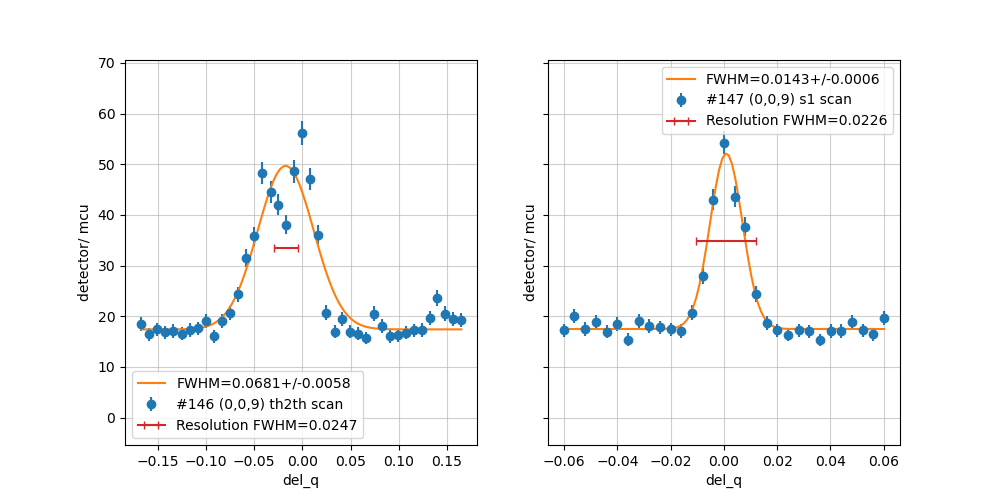

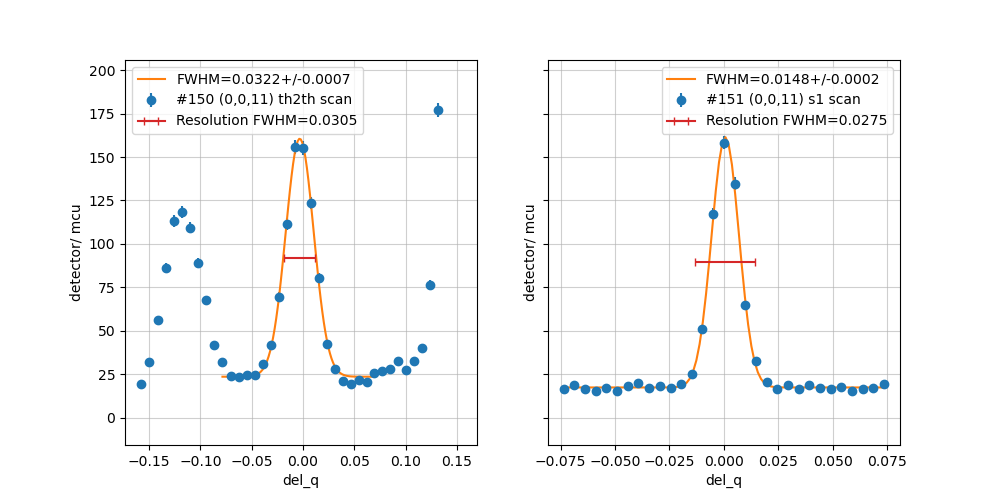

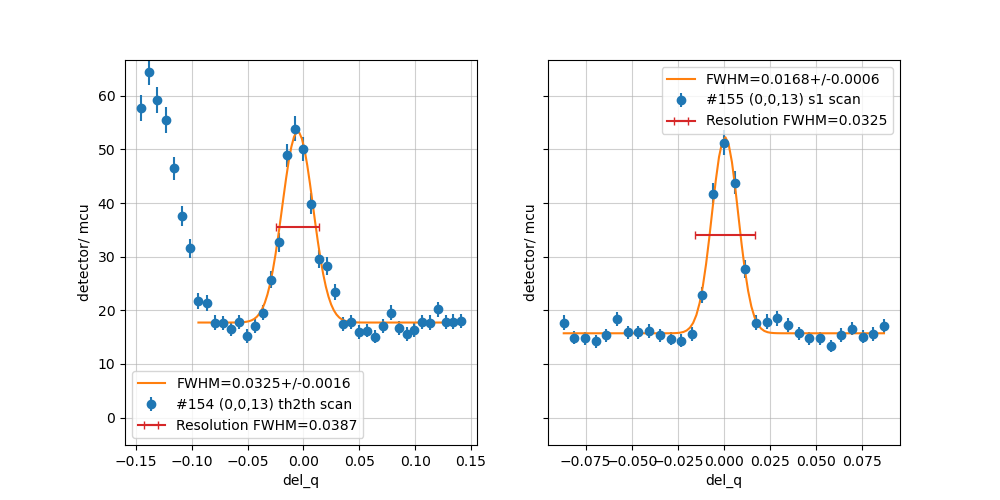

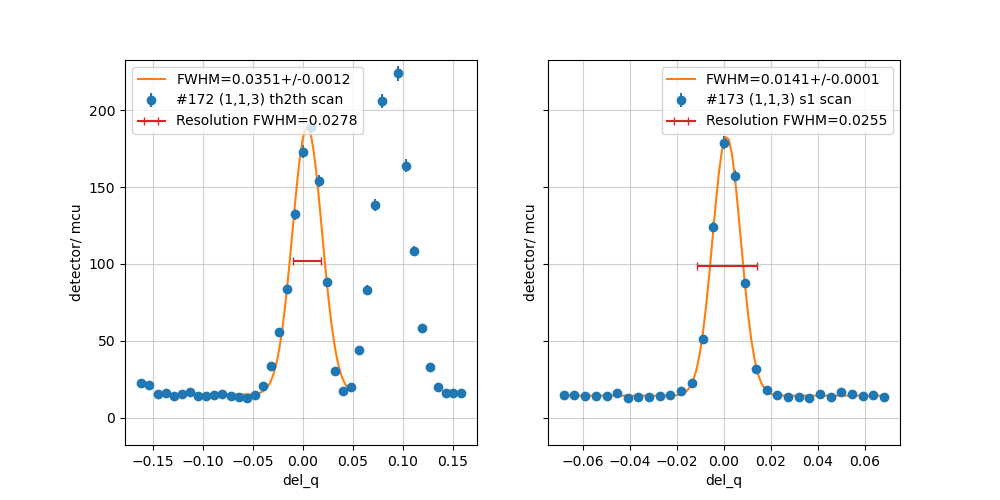

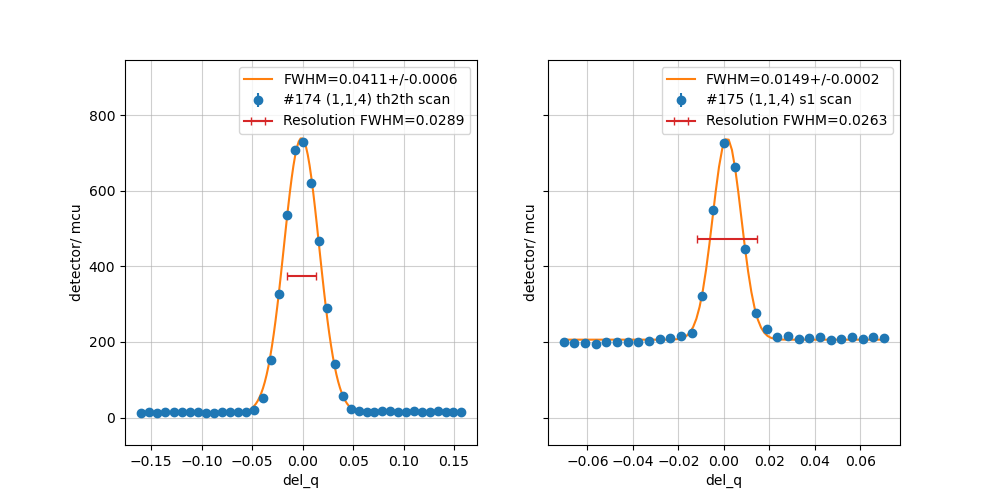

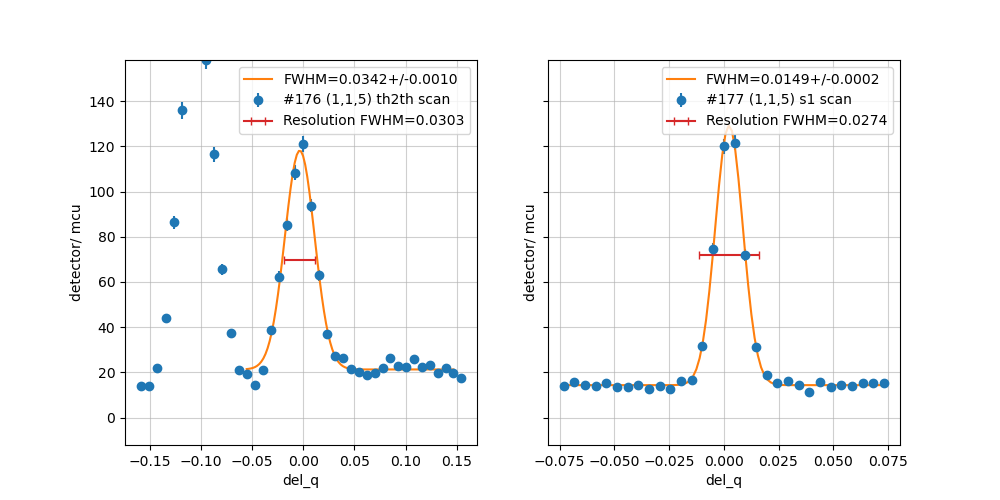

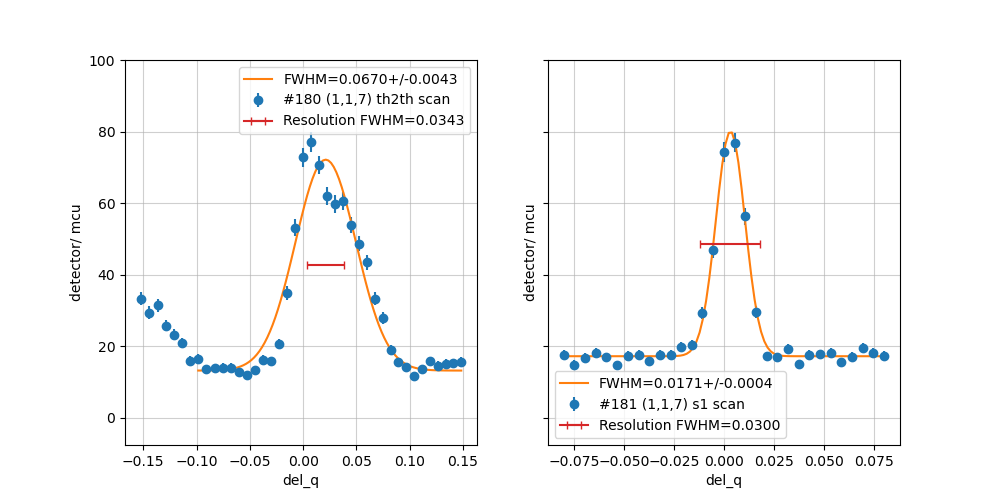

In [6]:
# bad peaks 
# scan_info = (hkl, (th2th scan num, s1, scan num), (fit ranges in del_q))
scan_info=(((0,0,9), (146,147),(None,None)), # double peaks
            ((0,0,11), (150,151),((-0.08,0.07),None)), #triple pekas
            ((0,0,13), (154,155),((-0.1,0.15),None)), # double peaks
            ((1,1,3), (172,173),((-0.13,0.05),None)), # double
            ((1,1,4), (174,175),((-0.13,0.05),None)),# on a powder line
            ((1,1,5), (176,177),((-0.06,0.15),None)),# double
            ((1,1,7), (180,181),((-0.10,0.15),None)), # double peak
           )

for info in scan_info:
    hkl, scans, fit_ranges = info
    analyze_fwhm(hkl, scans, fit_ranges)

/tmp/ipykernel_47694/703617612.py:78: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axes = plt.subplots(ncols=2,sharey=True,figsize=(10,5))


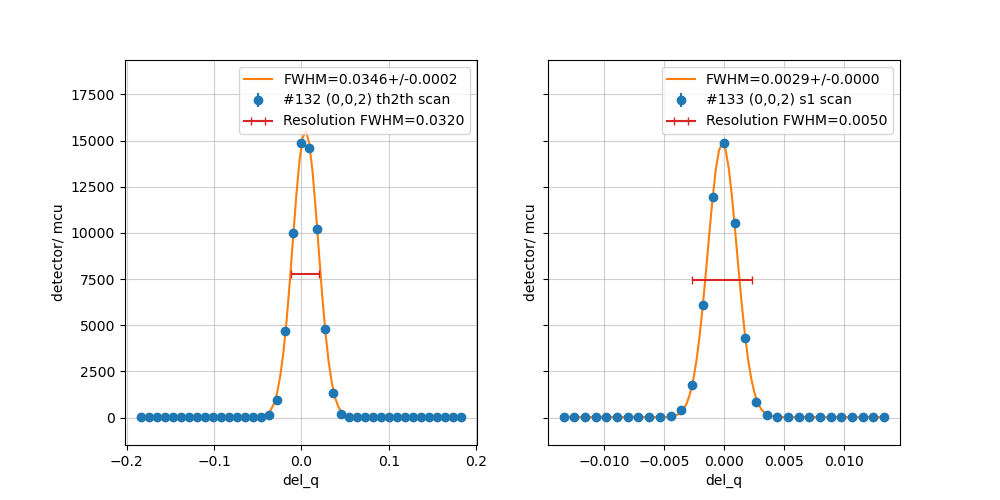

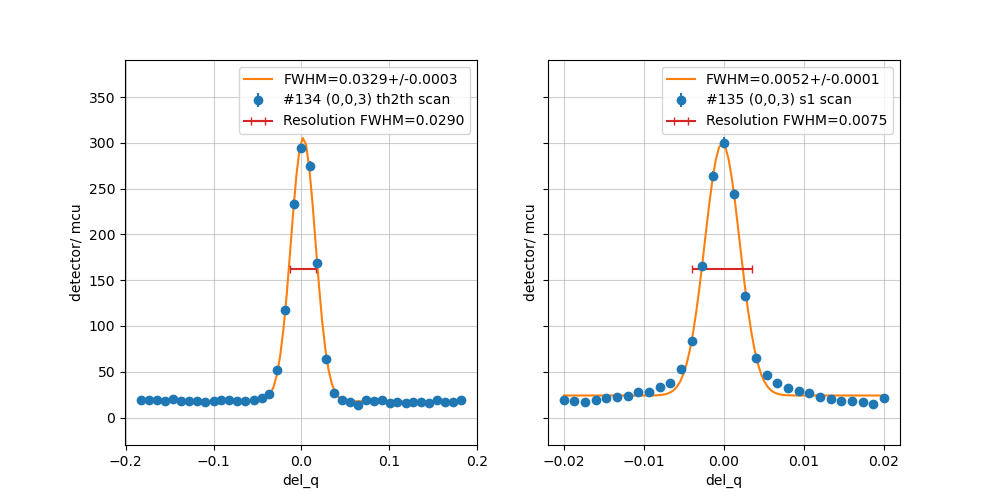

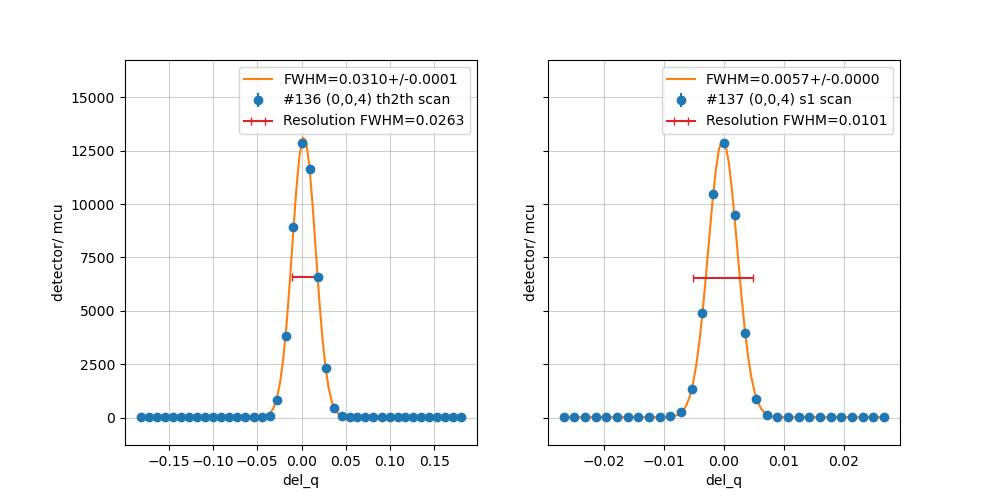

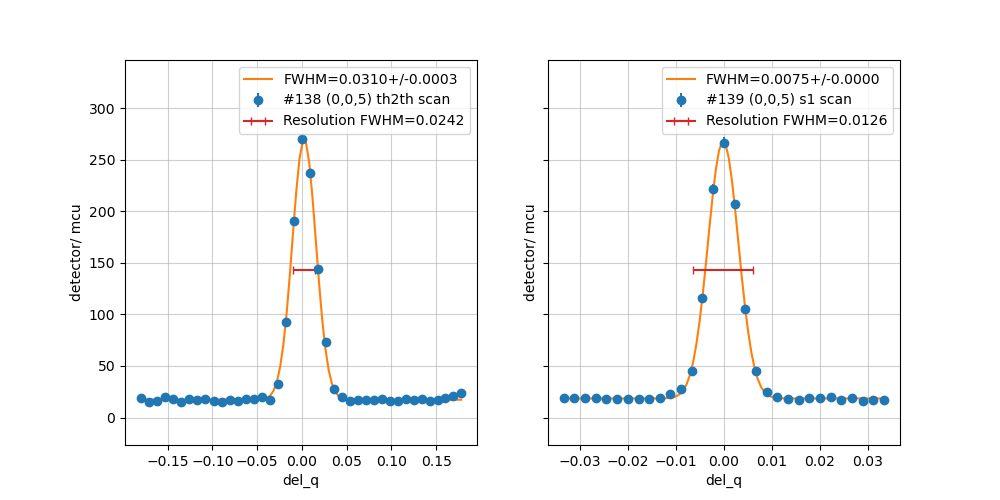

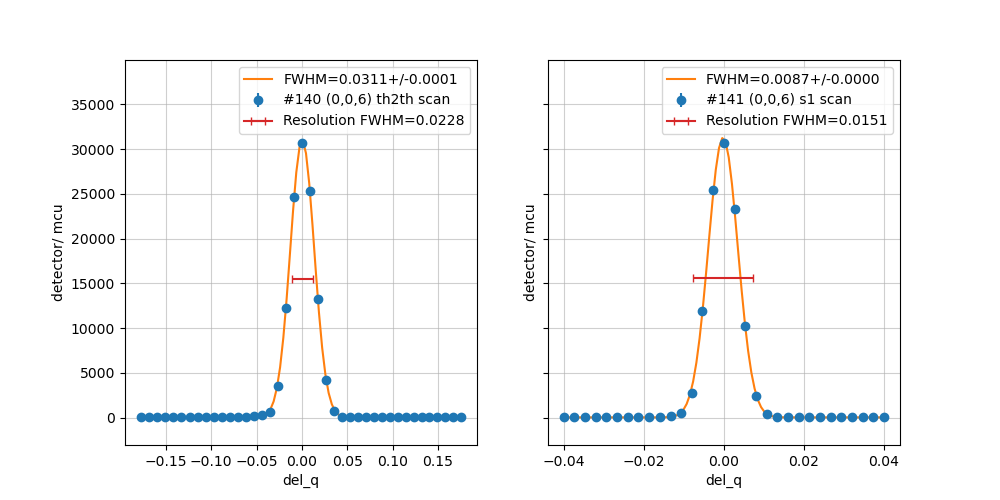

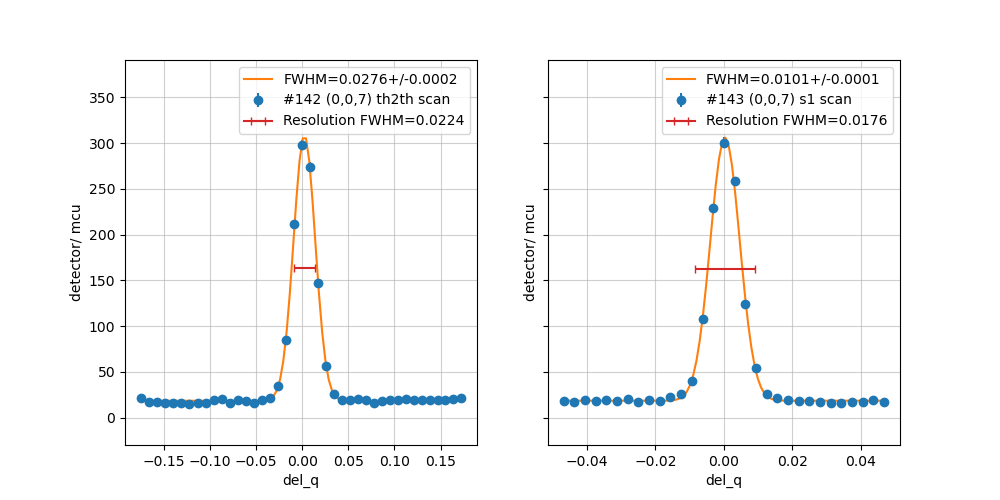

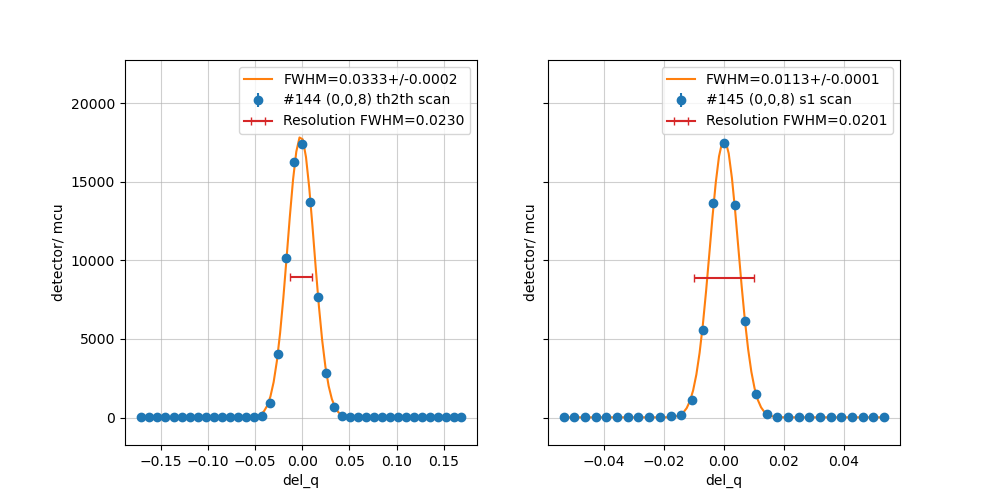

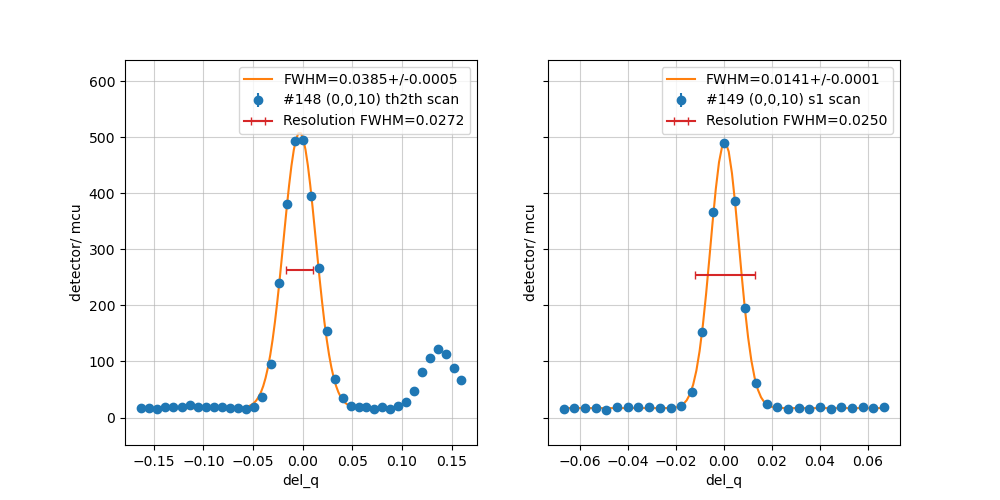

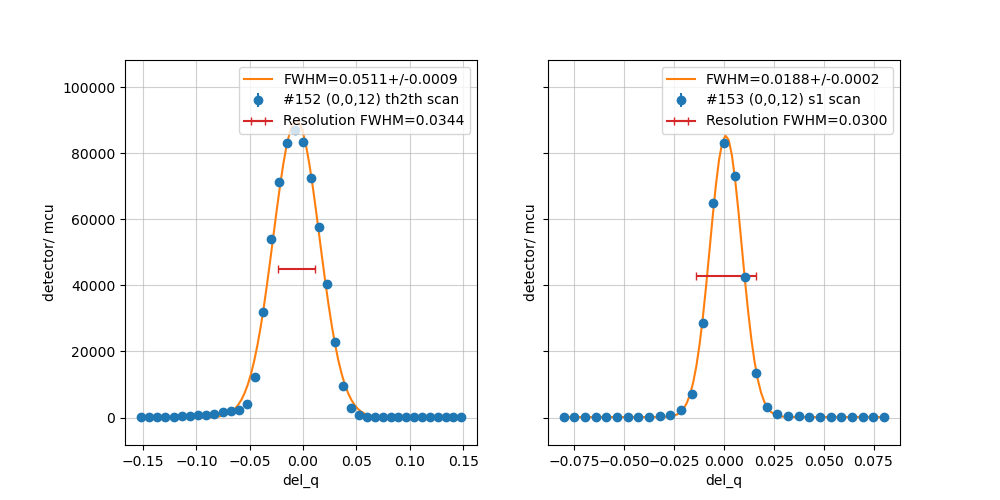

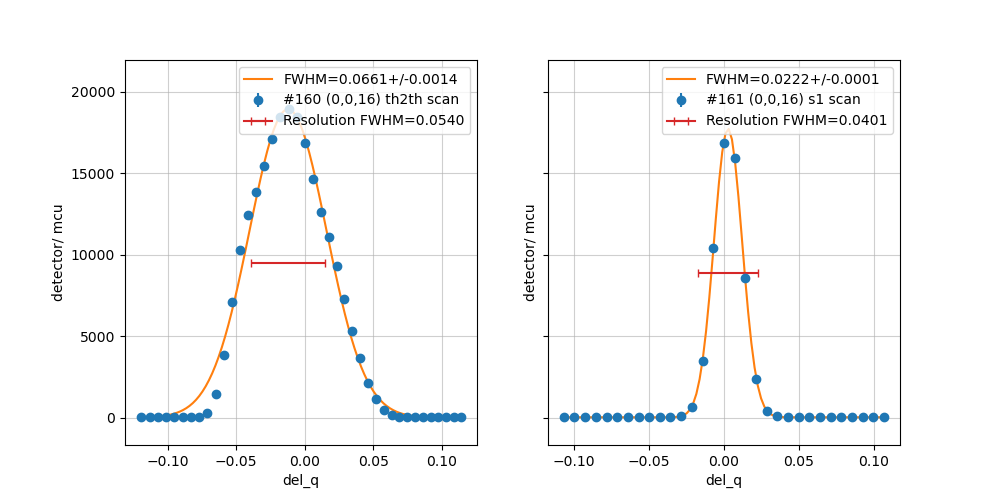

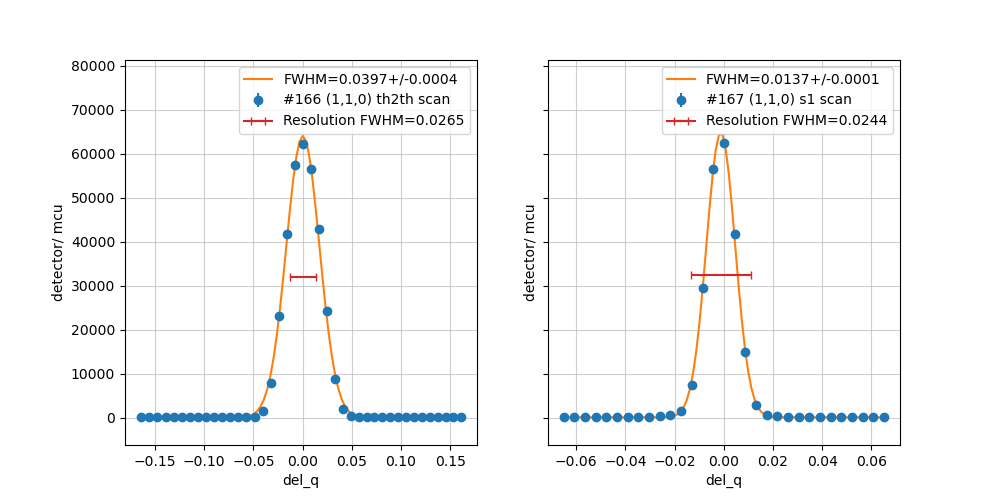

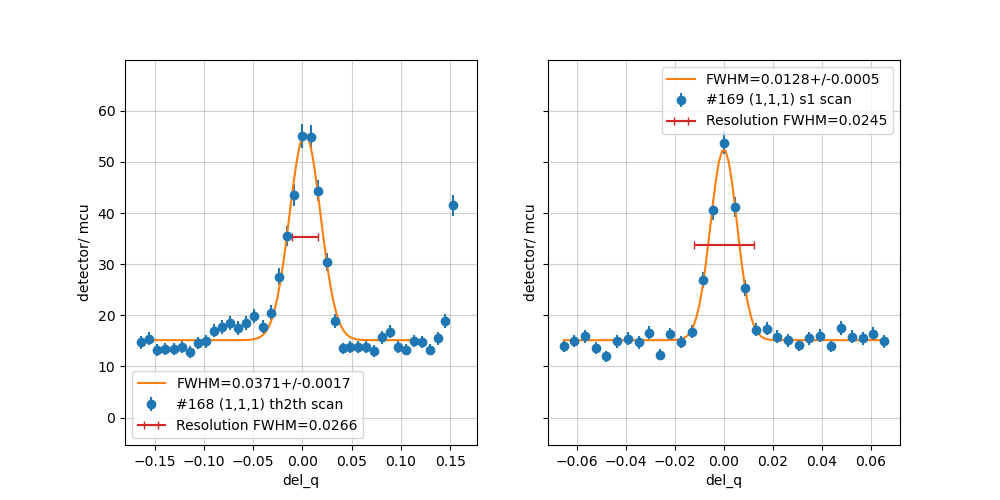

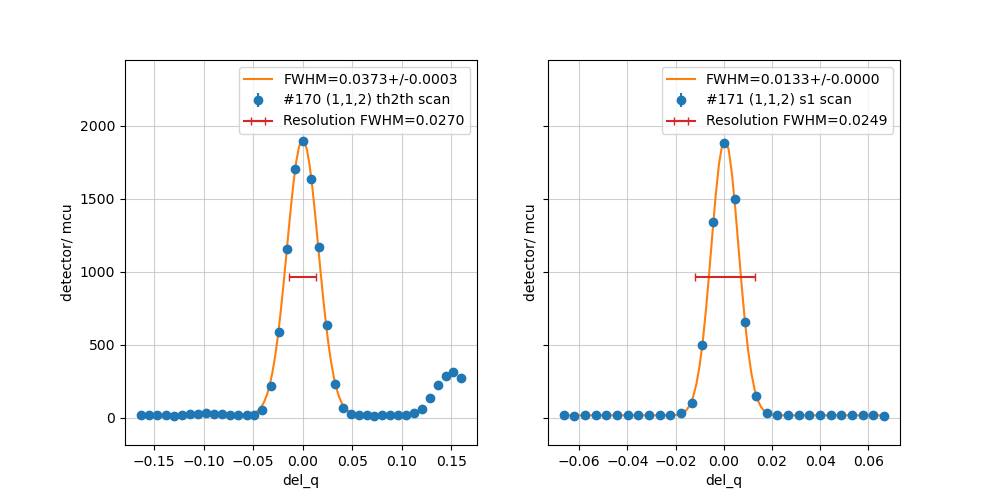

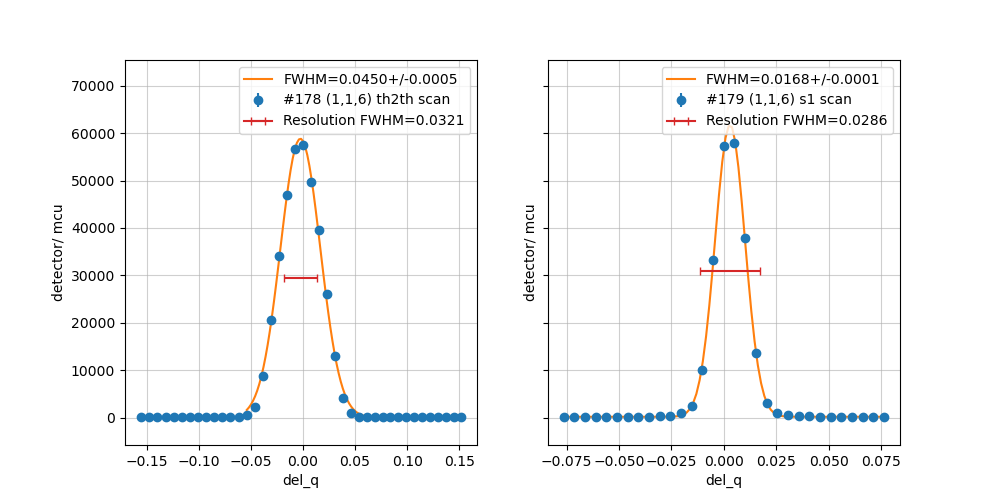

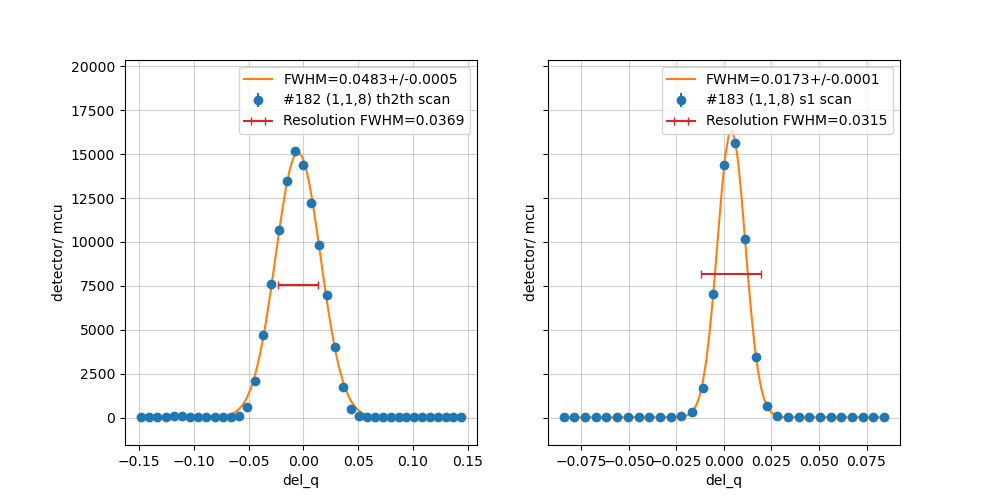

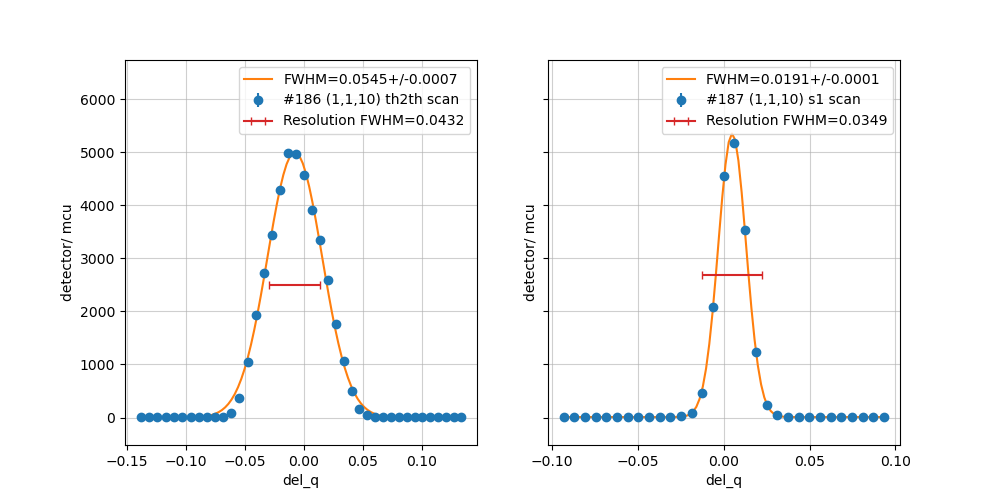

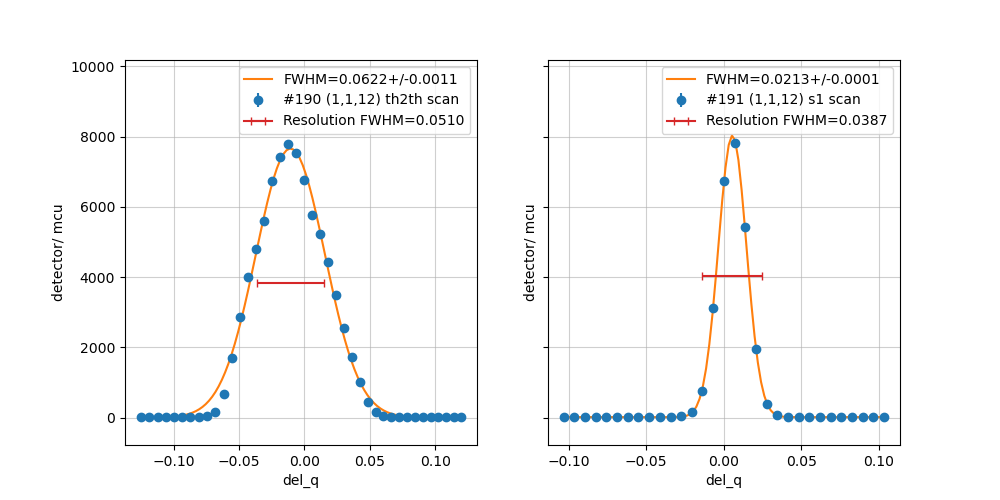

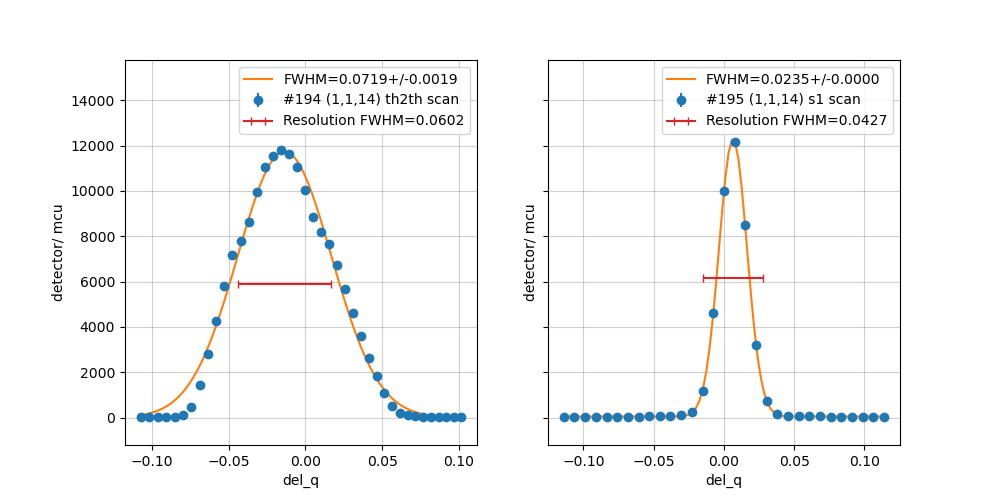

In [7]:
# scan_info = (hkl, (th2th scan num, s1, scan num), (fit ranges in del_q))
scan_info=(((0,0,2), (132,133),(None,None)),
            ((0,0,3), (134,135),(None,None)),
            ((0,0,4), (136,137),(None,None)),
            ((0,0,5), (138,139),(None,None)),
            ((0,0,6), (140,141),(None,None)),
            ((0,0,7), (142,143),(None,None)),
            ((0,0,8), (144,145),(None,None)),
            # ((0,0,9), (146,147),(None,None)), # double peaks
            ((0,0,10), (148,149),((-0.15,0.09),None)),
            #((0,0,11), (150,151),((-0.08,0.07),None)),
            ((0,0,12), (152,153),(None,None)), # having issues if use errorbar
            #((0,0,13), (154,155),((-0.1,0.15),None)),
            ((0,0,16), (160,161),(None,None)),
            ((1,1,0), (166,167),(None,None)),
            ((1,1,1), (168,169),((-0.16,0.12),None)),
            ((1,1,2), (170,171),((-0.16,0.12),None)),
            #((1,1,3), (172,173),((-0.13,0.05),None)),
            #((1,1,4), (174,175),((-0.13,0.05),None)),# on a powder line
            #((1,1,5), (176,177),((-0.06,0.15),None)),
            ((1,1,6), (178,179),((-0.06,0.15),None)),
            # ((1,1,7), (180,181),((-0.10,0.15),None)), # double peak
            ((1,1,8), (182,183),(None,None)),
            ((1,1,10), (186,187),(None,None)),
            ((1,1,12), (190,191),(None,None)),
            ((1,1,14), (194,195),(None,None)),
           )


# ------------------------ outputs to be collected --------------------
q_list=[]
s1_list=[]
hkl_list=[]
exp_fwhm_th2th=[]
exp_fwhm_s1=[]
cn_fwhm_th2th=[]
cn_fwhm_s1=[]

for info in scan_info:
    hkl, scans, fit_ranges = info
    q, s1,fwhm_th2th, fwhm_s1, cn_th2th, cn_s1= analyze_fwhm(hkl, scans, fit_ranges)
    # ------------------ collect output ---------------------------
    hkl_list.append(hkl)
    q_list.append(q)
    s1_list.append(s1)
    exp_fwhm_th2th.append(fwhm_th2th)
    exp_fwhm_s1.append(fwhm_s1)
    cn_fwhm_th2th.append(cn_th2th)
    cn_fwhm_s1.append(cn_s1)

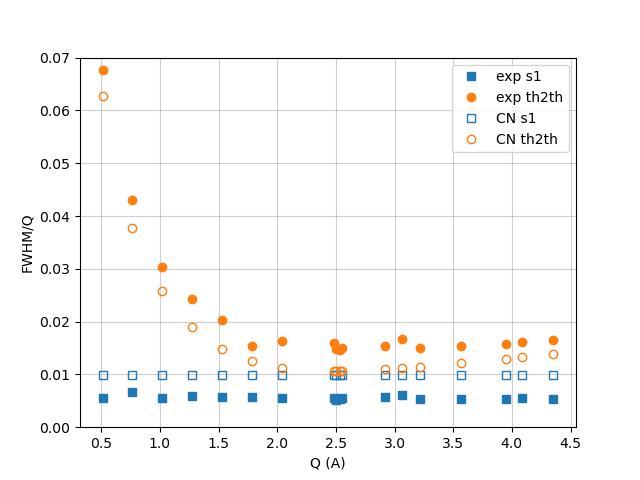

In [8]:
fig, ax=plt.subplots()
ax.set_xlabel("Q (A)")
ax.set_ylabel("FWHM/Q")
ax.set_ylim([0,0.07])
ax.plot(q_list,np.array(exp_fwhm_s1)/np.array(q_list),'s',label="exp s1")
ax.plot(q_list,np.array(exp_fwhm_th2th)/np.array(q_list),'o',label="exp th2th")
ax.plot(q_list,np.array(cn_fwhm_s1)/np.array(q_list),'s', markerfacecolor='none',label="CN s1",c="C0")
ax.plot(q_list,np.array(cn_fwhm_th2th)/np.array(q_list),'o', markerfacecolor='none',label="CN th2th",c="C1")

ax.legend()
ax.grid(alpha=0.6)

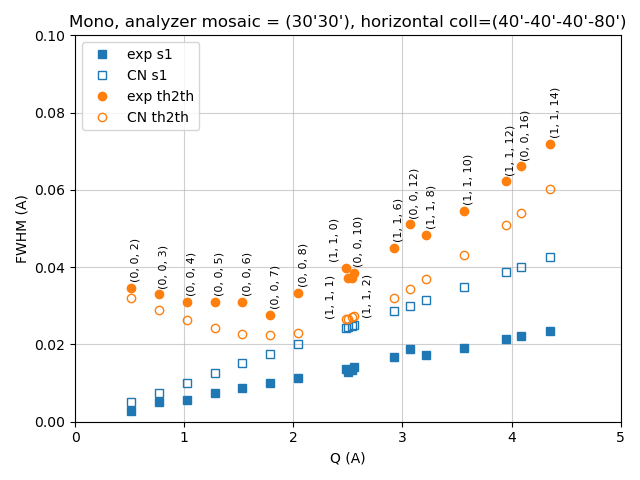

In [61]:
fig, ax=plt.subplots()
ax.set_xlabel("Q (A)")
ax.set_ylabel("FWHM (A)")
ax.set_ylim([0,0.1])
ax.set_xlim([0,5])
ax.plot(q_list,exp_fwhm_s1,'s',label="exp s1")
ax.plot(q_list,cn_fwhm_s1,'s', markerfacecolor='none',label="CN s1",c="C0")
ax.plot(q_list,exp_fwhm_th2th,'o',label="exp th2th")
ax.plot(q_list,cn_fwhm_th2th,'o', markerfacecolor='none',label="CN th2th",c="C1")
for i, hkl in enumerate(hkl_list):
    x=q_list[i]
    y= exp_fwhm_th2th[i]+0.002
    # mannual ajdjust position
    if hkl ==(1,1,0):
        x-=0.15
    if hkl ==(1,1,1):
        x-=0.2
        y-=0.012
    if hkl==(1,1,2):
        x+=0.1
        y-=0.012
   
    ax.annotate(hkl, (x,y),rotation=90,fontsize=8)

ax.legend(loc=2)
ax.grid(alpha=0.6)
ax.set_title("Mono, analyzer mosaic = (30'30'), horizontal coll=(40'-40'-40'-80')")
plt.tight_layout()

In [40]:
hkl_list[0]==(0,0,2)

True